In [1]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np


from cued_sf2_lab.familiarisation import load_mat_img, plot_image

from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.laplacian_pyramid import bpp

from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.dct import regroup
from cued_sf2_lab.dct import colxfm
from cued_sf2_lab.lbt import pot_ii


In [2]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

In [3]:
# Code for LBT: pot, dct, idct, then ipot.

def pot(X, N, s = 1):
    Xp = X.copy() # copy the non-transformed edges directly from X
    Xc = X.copy()

    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)
    
    # First do XP =  PF * X
    Xp = colxfm(Xp[t,:],pf)
    Xp = colxfm(Xp[:,t].T, pf).T

    for i in range(256-N):
        for j in range(256-N):
            Xc[int(i+N/2),int(j+N/2)] = Xp[i,j]

    return Xc


def dct(X, N):
    cn = dct_ii(N)
    Y = colxfm(colxfm(X, cn).T, cn).T
    return Y

def dct_regroup(Y, N):
    Yr = regroup(Y, N)/N
    return Yr    

def dct_reshape(Yr, N = 8):
    # Reshape the image into a 4D array with shape (8, 32, 8, 32)
    Yrr = Yr.reshape(N, 256 // N, N, 256 // N) # TODO Variable N
    # Permute the axes to obtain the desired shape (8, 8, 32, 32)
    Yrr = Yrr.transpose(0, 2, 1, 3)
    return Yrr


def idct(Y, N):
    cn = dct_ii(N)
    Zp = colxfm(colxfm(Y.T, cn.T).T, cn.T)
    return Zp


def ipot(Zp, N, s = 1):
    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)

    Z = Zp
    Z2 = Zp
    Z = colxfm(Z[:,t].T,pr.T).T
    Z = colxfm(Z[t,:],pr.T)
    for i in range(256-N):
        for j in range(256-N):
            Z2[int(i+N/2),int(j+N/2)] = Z[i,j]
    return Z2

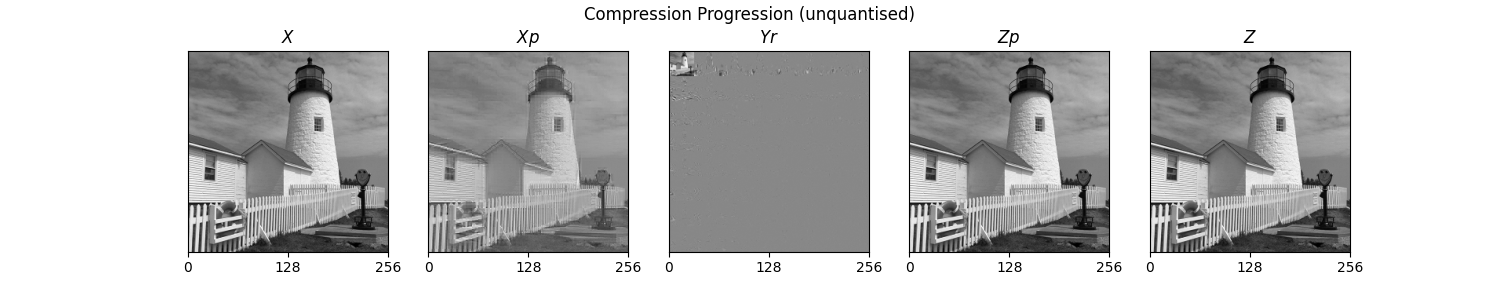

In [4]:
# Compression Progression (unquantised)
Xp = pot(X, N=8, s=1)
Y = dct(Xp, N=8)
Yr = dct_regroup(Y, N=8)
Zp = idct(Y, N=8)
Z = ipot(Zp, N=8, s=1)



# Plot multiple images
titles = ["X", "Xp", "Yr", "Zp", "Z"]
imgs = [X, Xp, Yr, Zp, Z]
fig, axs = plt.subplots(1, len(imgs), figsize=(15,3))
fig.suptitle("Compression Progression (unquantised)")
for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

RMS = 3.8183956268583796
bits = 107400.60632513612
Compression Ratio (wrt X) = 4.593997870804495
Compression Ratio (wrt Xq) = 2.1240013843878858


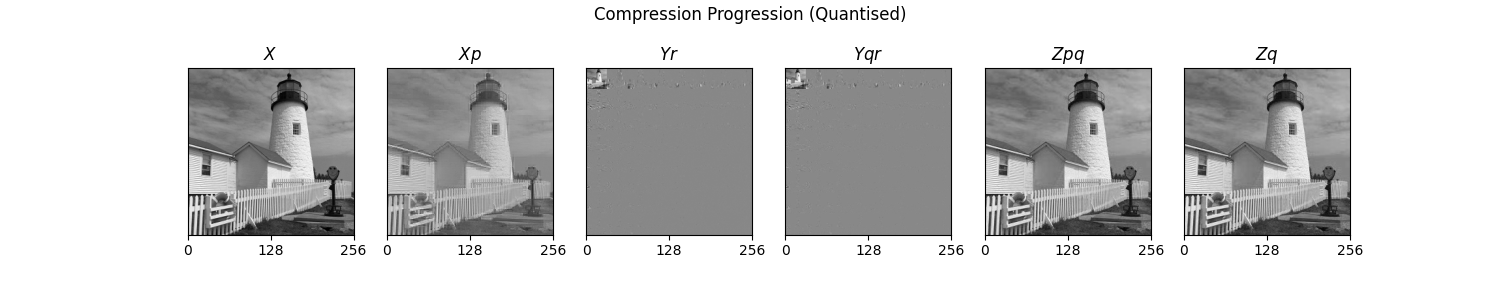

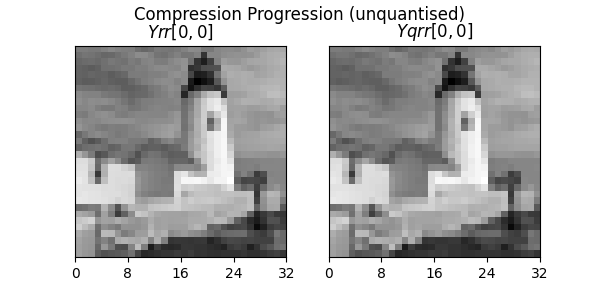

In [5]:
# Compression Progression (Quantised)
Xp = pot(X, N=8, s=1)
Y = dct(Xp, N=8)
Yr = dct_regroup(Y, N=8)
Yrr = dct_reshape(Yr, N=8)

step = 17
Yq = quantise(Y, step)

Yqr = dct_regroup(Yq, N=8)
Yqrr = dct_reshape(Yqr, N=8)
Zpq = idct(Yq, N=8)
Zq = ipot(Zpq, N=8, s=1)

rms = np.std(Zq-X)
bits_Yq = bpp(Yq) * Yq.size
bits_X = bpp(X) * X.size
cr = bits_X / bits_Yq               # cr means compression ratio w.r.t. X from now on!!!!!!!!!!!!!!!!!
print(f"RMS = {rms}")
print(f"bits = {bits_Yq}")
print(f"Compression Ratio (wrt X) = {cr}")
print(f"Compression Ratio (wrt Xq) = {bpp(quantise(X,step))*X.size / bits_Yq}")



# Plot multiple images
titles = ["X", "Xp", "Yr", "Yqr", "Zpq", "Zq"]
imgs = [X, Xp, Yr, Yqr, Zpq, Zq]
fig, axs = plt.subplots(1, len(imgs), figsize=(15,3))
fig.suptitle("Compression Progression (Quantised)")
for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')


# Plot multiple images
titles = ["Yrr[0,0]", "Yqrr[0,0]"]
imgs = [Yrr[0,0], Yqrr[0,0]]
fig, axs = plt.subplots(1, len(imgs), figsize=(6,3))
fig.suptitle("Compression Progression (unquantised)")
for ax, img, title in zip(axs, imgs, titles):
    plot_image(img, ax=ax)
    ax.set(yticks=[], title=f'${title}$')

In [12]:
def lbt(X, N=8, s=1, step=17, k=0.5): # rise1 = step/2 by default, so k=0.5 by default
    Xp = pot(X, N, s)
    Y = dct(Xp, N)
    return Y

def ilbt(Yq, N=8, s=1):
    Zpq = idct(Yq, N)
    Zq = ipot(Zpq, N, s)
    return Zq

def full_process_results(X, N=8, s=1, step=17, k=0.5): 
    Y = lbt(X, N, s, step, k)
    Yq = quantise(Y, step, rise1=k*step)
    Zq = ilbt(Yq, N, s)

    rms = np.std(Zq-X)
    bits_Yq = bpp(Yq) * Yq.size
    bits_X = bpp(X) * X.size
    cr = bits_X / bits_Yq  

    return rms, cr


In [13]:
print(full_process_results(X, N=8, s=1, step=17, k=0.5))

(3.8183956268583796, 4.593997870804495)
